In [338]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import re
import os

In [339]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Drop outliers from the training data.

In [340]:
outlier_index = list(train_df[
    (train_df.SibSp > 6) | (train_df.Parch > 6) | (train_df.Fare > 300)
].index)

train_df.drop(outlier_index, axis=0, inplace=True)
outlier_index

[159, 180, 201, 258, 324, 679, 737, 792, 846, 863]

In [341]:
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [342]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          293 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


In [343]:
y = train_df.Survived

In [344]:
salut_map = {
    r'.*\sMr\.\s.*': 'Mr',
    r'.*\sMrs\.\s.*': 'Mrs',
    r'.*\sMiss\.\s.*': 'Miss',
    r'.*\sMaster\.\s.*': 'Master',
    
    # Ignore rare ones.
#    r'.*\sMs\.\s.*': 'Miss',
#    r'.*\sDr\.\s.*': 'Dr',
#    r'.*\sRev\.\s.*': 'Rev',
#    r'.*\sDon\.\s.*': 'Don',
#    r'.*\sMajor\.\s.*': 'Major',
#    r'.*\sMme\.\s.*': 'Mme',
}

def extract_salut(name: str) -> str:
    for regex, salut in salut_map.items():
        if re.match(regex, name):
            return salut
    return 'Other'

In [345]:
full_df['Salut'] = full_df.Name.map(extract_salut)
full_df.groupby('Salut').Salut.describe()

,count,unique,top,freq
Salut,,,,
Master,60,1,Master,60
Miss,256,1,Miss,256
Mr,752,1,Mr,752
Mrs,197,1,Mrs,197
Other,34,1,Other,34


In [346]:
full_df['IsAlone'] = (full_df['SibSp'] + full_df['Parch'] == 0) * 1
ages = full_df.groupby(['Sex', 'Pclass', 'IsAlone', 'Salut']).Age.median()

# Fill NaN
ages['female', 3, 1, 'Other'] = full_df[ (full_df.Sex=='female') & (full_df.Pclass==3) & full_df.IsAlone ].Age.median()
ages['male', 3, 1, 'Master'] = full_df[ (full_df.Sex=='male') & (full_df.Pclass==3) & (full_df.Salut=='Master') ].Age.median()

ages

Sex     Pclass  IsAlone  Salut 
female  1       0        Miss      22.0
                         Mrs       44.5
                         Other     48.0
                1        Miss      32.5
                         Mrs       55.0
                         Other     28.5
        2       0        Miss      13.0
                         Mrs       29.0
                1        Miss      28.0
                         Mrs       32.0
                         Other     28.0
        3       0        Miss       9.0
                         Mrs       30.5
                1        Miss      22.0
                         Mrs       38.0
                         Other     22.0
male    1       0        Master     6.0
                         Mr        39.0
                         Other     49.5
                1        Mr        42.0
                         Other     48.5
        2       0        Master     2.0
                         Mr        32.0
                         Other     30.0
        

In [347]:
fares = full_df.groupby(['Pclass', 'Embarked']).Fare.median()
fares

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [398]:
def prep(df):
    X = pd.DataFrame((df['Sex'] == 'female') * 1)
    df['IsAlone'] = (df['SibSp'] + df['Parch'] == 0) * 1
    X['IsAlone'] = df['IsAlone']
    df['Salut'] = df.Name.map(extract_salut)

    X['AgeNull'] = df.Age.isnull()
    ages_default = df.apply(lambda s: ages[s['Sex'], s['Pclass'], s['IsAlone'], s['Salut']], axis=1)
    ages_complete = df.Age.fillna(ages_default).astype(int)
    X['Age'] = ages_complete - (ages_complete % 5)  # Round by 5.
    
    df['Embarked'].fillna('S', inplace=True)
    fares_default = df.apply(lambda s: fares[s['Pclass'], s['Embarked']], axis=1)
    fares_complete = df.Fare.fillna(fares_default)
    X['Fare'] = np.log(fares_complete + 1.0)

    dummy1 = pd.get_dummies(df.Pclass, prefix='Pclass')
    dummy2 = pd.get_dummies(df.Embarked, prefix='Emb')
    dummy3 = pd.get_dummies(df.Salut, prefix='Salut')

    X = pd.concat([X, dummy1, dummy2, dummy3], axis=1)

    cabin_prefix =  df.Cabin.str.extract('([A-Z]).*', expand=False)
    for prefix in ['E', 'D', 'A', 'B', 'C']:
        X['Cabin_' + prefix] = (cabin_prefix == prefix) * 1

    ticket_prefix = df.Ticket.str.extract('([A-Za-z].+) \d+', expand=False).str.replace(r'[./_ -]', '')
    for prefix in ['STONO2', 'WC']:
        X['Ticket_' + prefix] = (ticket_prefix == prefix) * 1

    # Drop unnecessary features.
    for col in ['Emb_Q', 'Salut_Mr']:
        X.drop(col, axis=1, inplace=True)
    return X

X = prep(train_df)
X.head()

,Sex,IsAlone,AgeNull,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Emb_C,Emb_S,...,Salut_Miss,Salut_Mrs,Salut_Other,Cabin_E,Cabin_D,Cabin_A,Cabin_B,Cabin_C,Ticket_STONO2,Ticket_WC
0,0,0,False,20,2.110213,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,False,35,4.280593,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,1,False,25,2.188856,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
3,1,0,False,35,3.990834,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,1,False,35,2.202765,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [400]:
m = XGBClassifier(
    n_jobs=4,
    nthread=4,
    seed=0,

    # Tuned:
    max_depth=5,
    reg_alpha=.03,
    scale_pos_weight=1.2,
    learning_rate=.05,
    n_estimators=300,
    max_delta_step=.3
)
m.fit(X, y)
for x in reversed(sorted(zip(m.feature_importances_, X.columns.values))):
    print(x)

(0.43399408, 'Fare')
(0.19337831, 'Age')
(0.062210038, 'Pclass_3')
(0.050822437, 'Sex')
(0.028258119, 'Salut_Master')
(0.027414594, 'Emb_C')
(0.025938423, 'AgeNull')
(0.021299031, 'Ticket_STONO2')
(0.020033741, 'Cabin_E')
(0.01982286, 'Emb_S')
(0.016870519, 'Cabin_C')
(0.014550823, 'Salut_Miss')
(0.011598482, 'Salut_Mrs')
(0.011598482, 'IsAlone')
(0.011176718, 'Cabin_D')
(0.010122311, 'Pclass_2')
(0.010122311, 'Pclass_1')
(0.0097005479, 'Ticket_WC')
(0.0094896667, 'Cabin_A')
(0.007380852, 'Salut_Other')
(0.0042176298, 'Cabin_B')


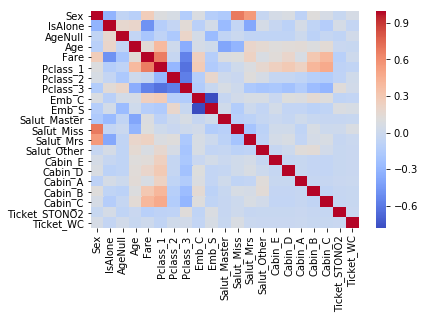

In [401]:
sns.heatmap(X.corr(), cmap='coolwarm')

In [402]:
help(XGBClassifier.__init__)

Help on function __init__ in module xgboost.sklearn:

__init__(self, max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [403]:
params = {
    # Fixed:
    'n_jobs': [4],
    'nthread':[4],
    'seed': [0],

    # Tuned:
    'max_depth': [5],  # default=3
    'reg_alpha': [.03], # default=0
    'scale_pos_weight':[1.2], # default=1
    'learning_rate':[0.05], # default=0.1
    'n_estimators':[300], # default=100
    'max_delta_step':[0.3], # default=0

    # Default is good:
    #'min_child_weight':[1],
    #'gamma':[0],
    #'subsample':[1],
    #'colsample_bytree':[1],
    #'objective':['binary:logistic'],
}

clf = GridSearchCV(XGBClassifier(), param_grid=params, cv=10, scoring='accuracy')
clf.fit(X, y)

print('Best Params: ', clf.best_params_)
print('Best Score: ', clf.best_score_)

Best Params:  {'max_depth': 5, 'n_estimators': 300, 'seed': 0, 'learning_rate': 0.05, 'nthread': 4, 'max_delta_step': 0.3, 'n_jobs': 4, 'reg_alpha': 0.03, 'scale_pos_weight': 1.2}
Best Score:  0.850170261067


# Accuracy Scores (CV=10)
- sex only: 0.786756453423
- sex + pclass: 0.775533108866
- sex + pclass + isalone: 0.791245791246
- sex + pclass + isalone + embark: 0.808080808081 (submit: 0.77990)
- sex + pclass + isalone + embark + age: 0.81593714927
- sex + pclass + isalone + embark + age + fare: 0.840628507295 (submit: 0.78468)
- sex + pclass + isalone + embark + age + fare + salut [with outliers]: 0.852974186308 (submit: TBD)
- sex + pclass + isalone + embark + age + fare + salut [drop outliers]: 0.850170261067 (submit: TBD)

In [361]:
tX = prep(test_df)
tY = clf.predict(tX)

In [362]:
ans = pd.DataFrame(test_df.PassengerId)
ans['Survived'] = tY
ans.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [363]:
def answer_exists(df):
    for csv in os.listdir():
        if not csv.endswith('.csv'):
            continue
        if not csv.startswith('out'):
            continue
        prev_df = pd.read_csv(csv)
        if (prev_df.Survived != ans.Survived).sum() == 0:
            print("Equivalent to", csv)
            return True

    print("No equivalent answer")
    return False

In [364]:
if not answer_exists(ans):
  out = 'out-xgb%d.csv' % len(os.listdir())
  ans.to_csv(out, index=False)
  print('New output:', out)

No equivalent answer
New output: out-xgb16.csv


In [332]:
os.listdir()

['EDA.ipynb',
 'out-xgb11.csv',
 'out-xgb10.csv',
 'test.csv',
 'out-xgb12.csv',
 'out-xgb9.csv',
 'out-xgb13.csv',
 'out-xgb14.csv',
 'out-xgb15.csv',
 'out-xgb2.csv',
 'out-xgb1.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'XGBoost.ipynb',
 'notes.md',
 'gender_submission.csv']